# <center>Sophia Hart, MS, MEng<center>
# <center>Wildfire Detection using Computer Vision<center>


## Goal and Data:
Wildfire is a davastating problem in California due to climate change. Last year, in 2021, there were 185 wildfires in California. Wildfires are usually detected by satellite and camera towel images. Human looking at these images causes fatiuge and error.

In this project, I downloaded fire and nonfire images from the internet, and built a convolution neural network by transfer learning with the pretrained Xception model to classify if an image shows there is or there is no wildfire. 


# Preprocess Data

In [5]:
# cell 01
import sagemaker
bucket = 'wildfire'
#prefix = ''
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import glob
import random

print("TensorFlow version: ", tf.__version__)

%load_ext tensorboard

2024-10-22 19:45:38.575089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version:  2.17.0


#### Divide all jpeg files into training and testing filenames

In [7]:

# Gather all the files from the fire and nonfire directories
# Some file names are jpg and some are jpeg
paths = glob.glob("./*fire/*.jp*g")

# Shuffle them because top is fire and bottom is nonfire images
random.shuffle(paths)

print("Total number of images ", len(paths))


Total number of images  8


In [8]:
# filenames for train and test sets

train_filenames = []
test_filenames = []
i = 0

for filename in paths:  
    
     # Send 25% (1 out of 4) of the images to testing set, the rest to training set
    if i % 4 == 0:
        test_filenames.append(filename)
    else: train_filenames.append(filename) 
    
    i += 1
      
print("Original number of files for training set: ", len(train_filenames), train_filenames)
print("Original number of files for testing set: ", len(test_filenames), test_filenames)

Original number of files for training set:  6 ['./nofire/nonfire15.jpeg', './nofire/nonfire13.jpeg', './nofire/nonfire12.jpeg', './fire/fire13.jpg', './fire/fire1.jpg', './fire/fire12.jpg']
Original number of files for testing set:  2 ['./fire/fire10.jpg', './nofire/nonfire16.jpeg']


#### Create Training and Testing Datasets

Training image dataset shape:  (6, 224, 224, 3)
Testing image dataset shape:  (2, 224, 224, 3)


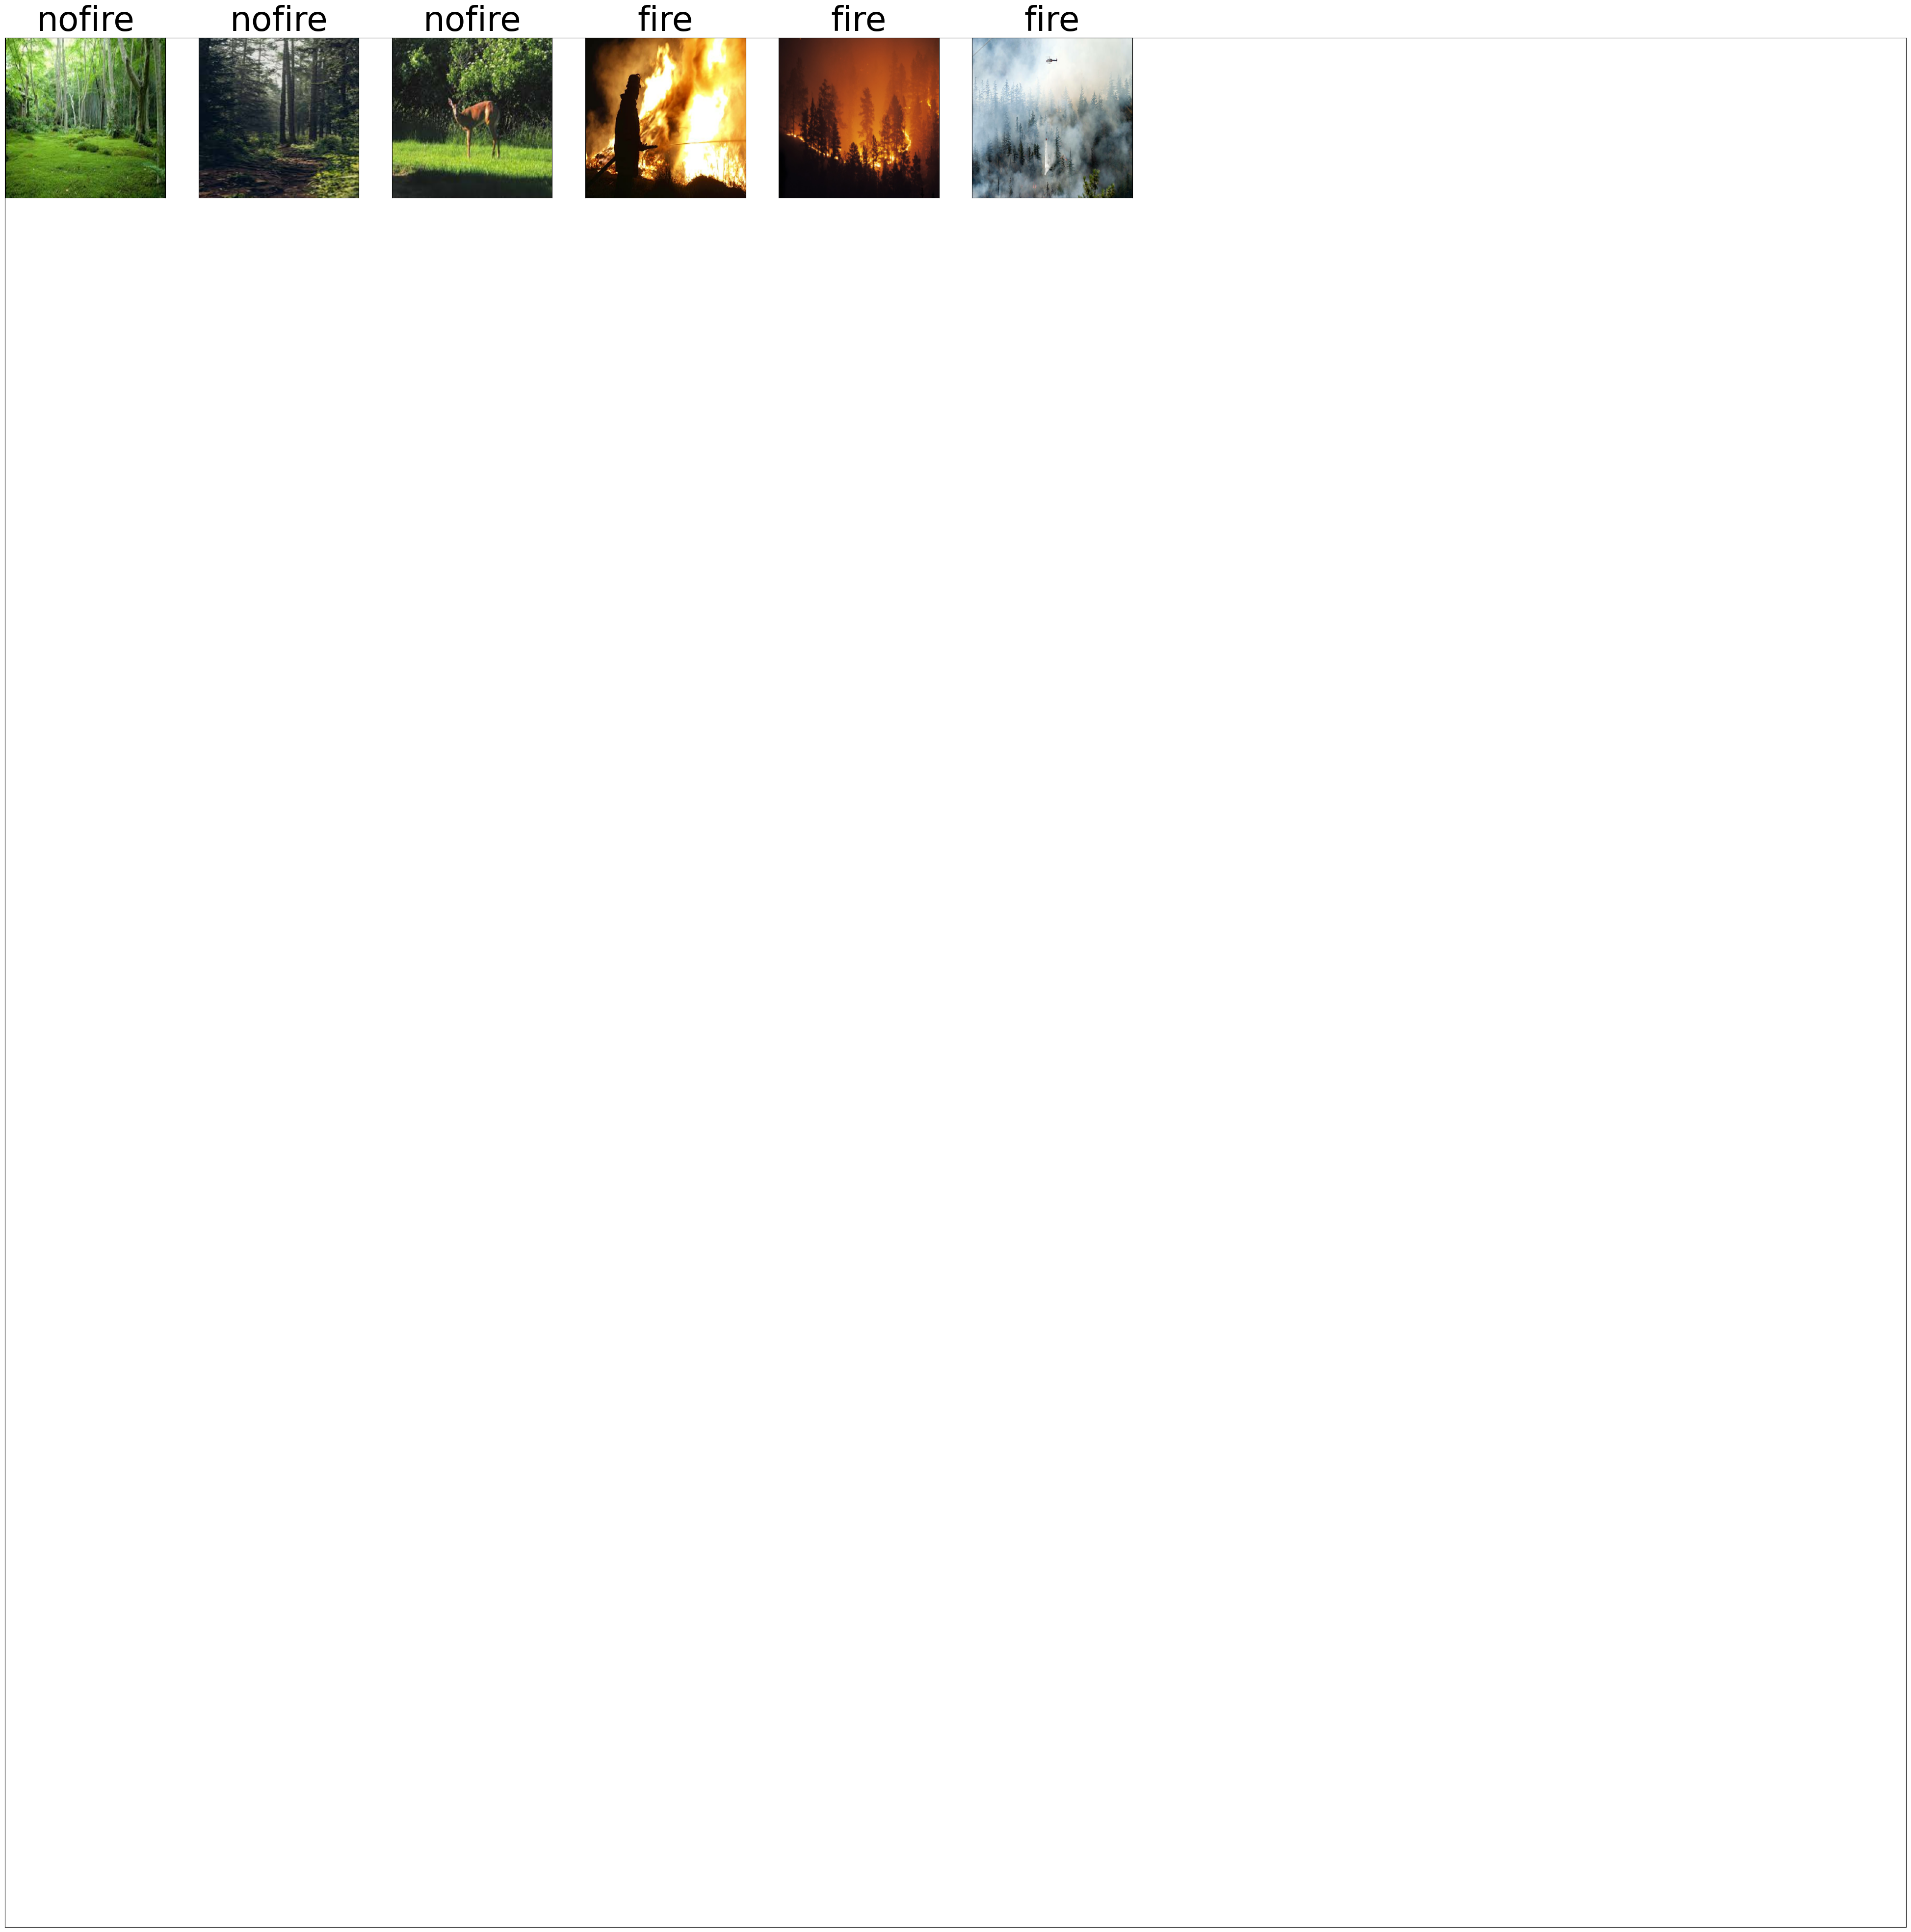

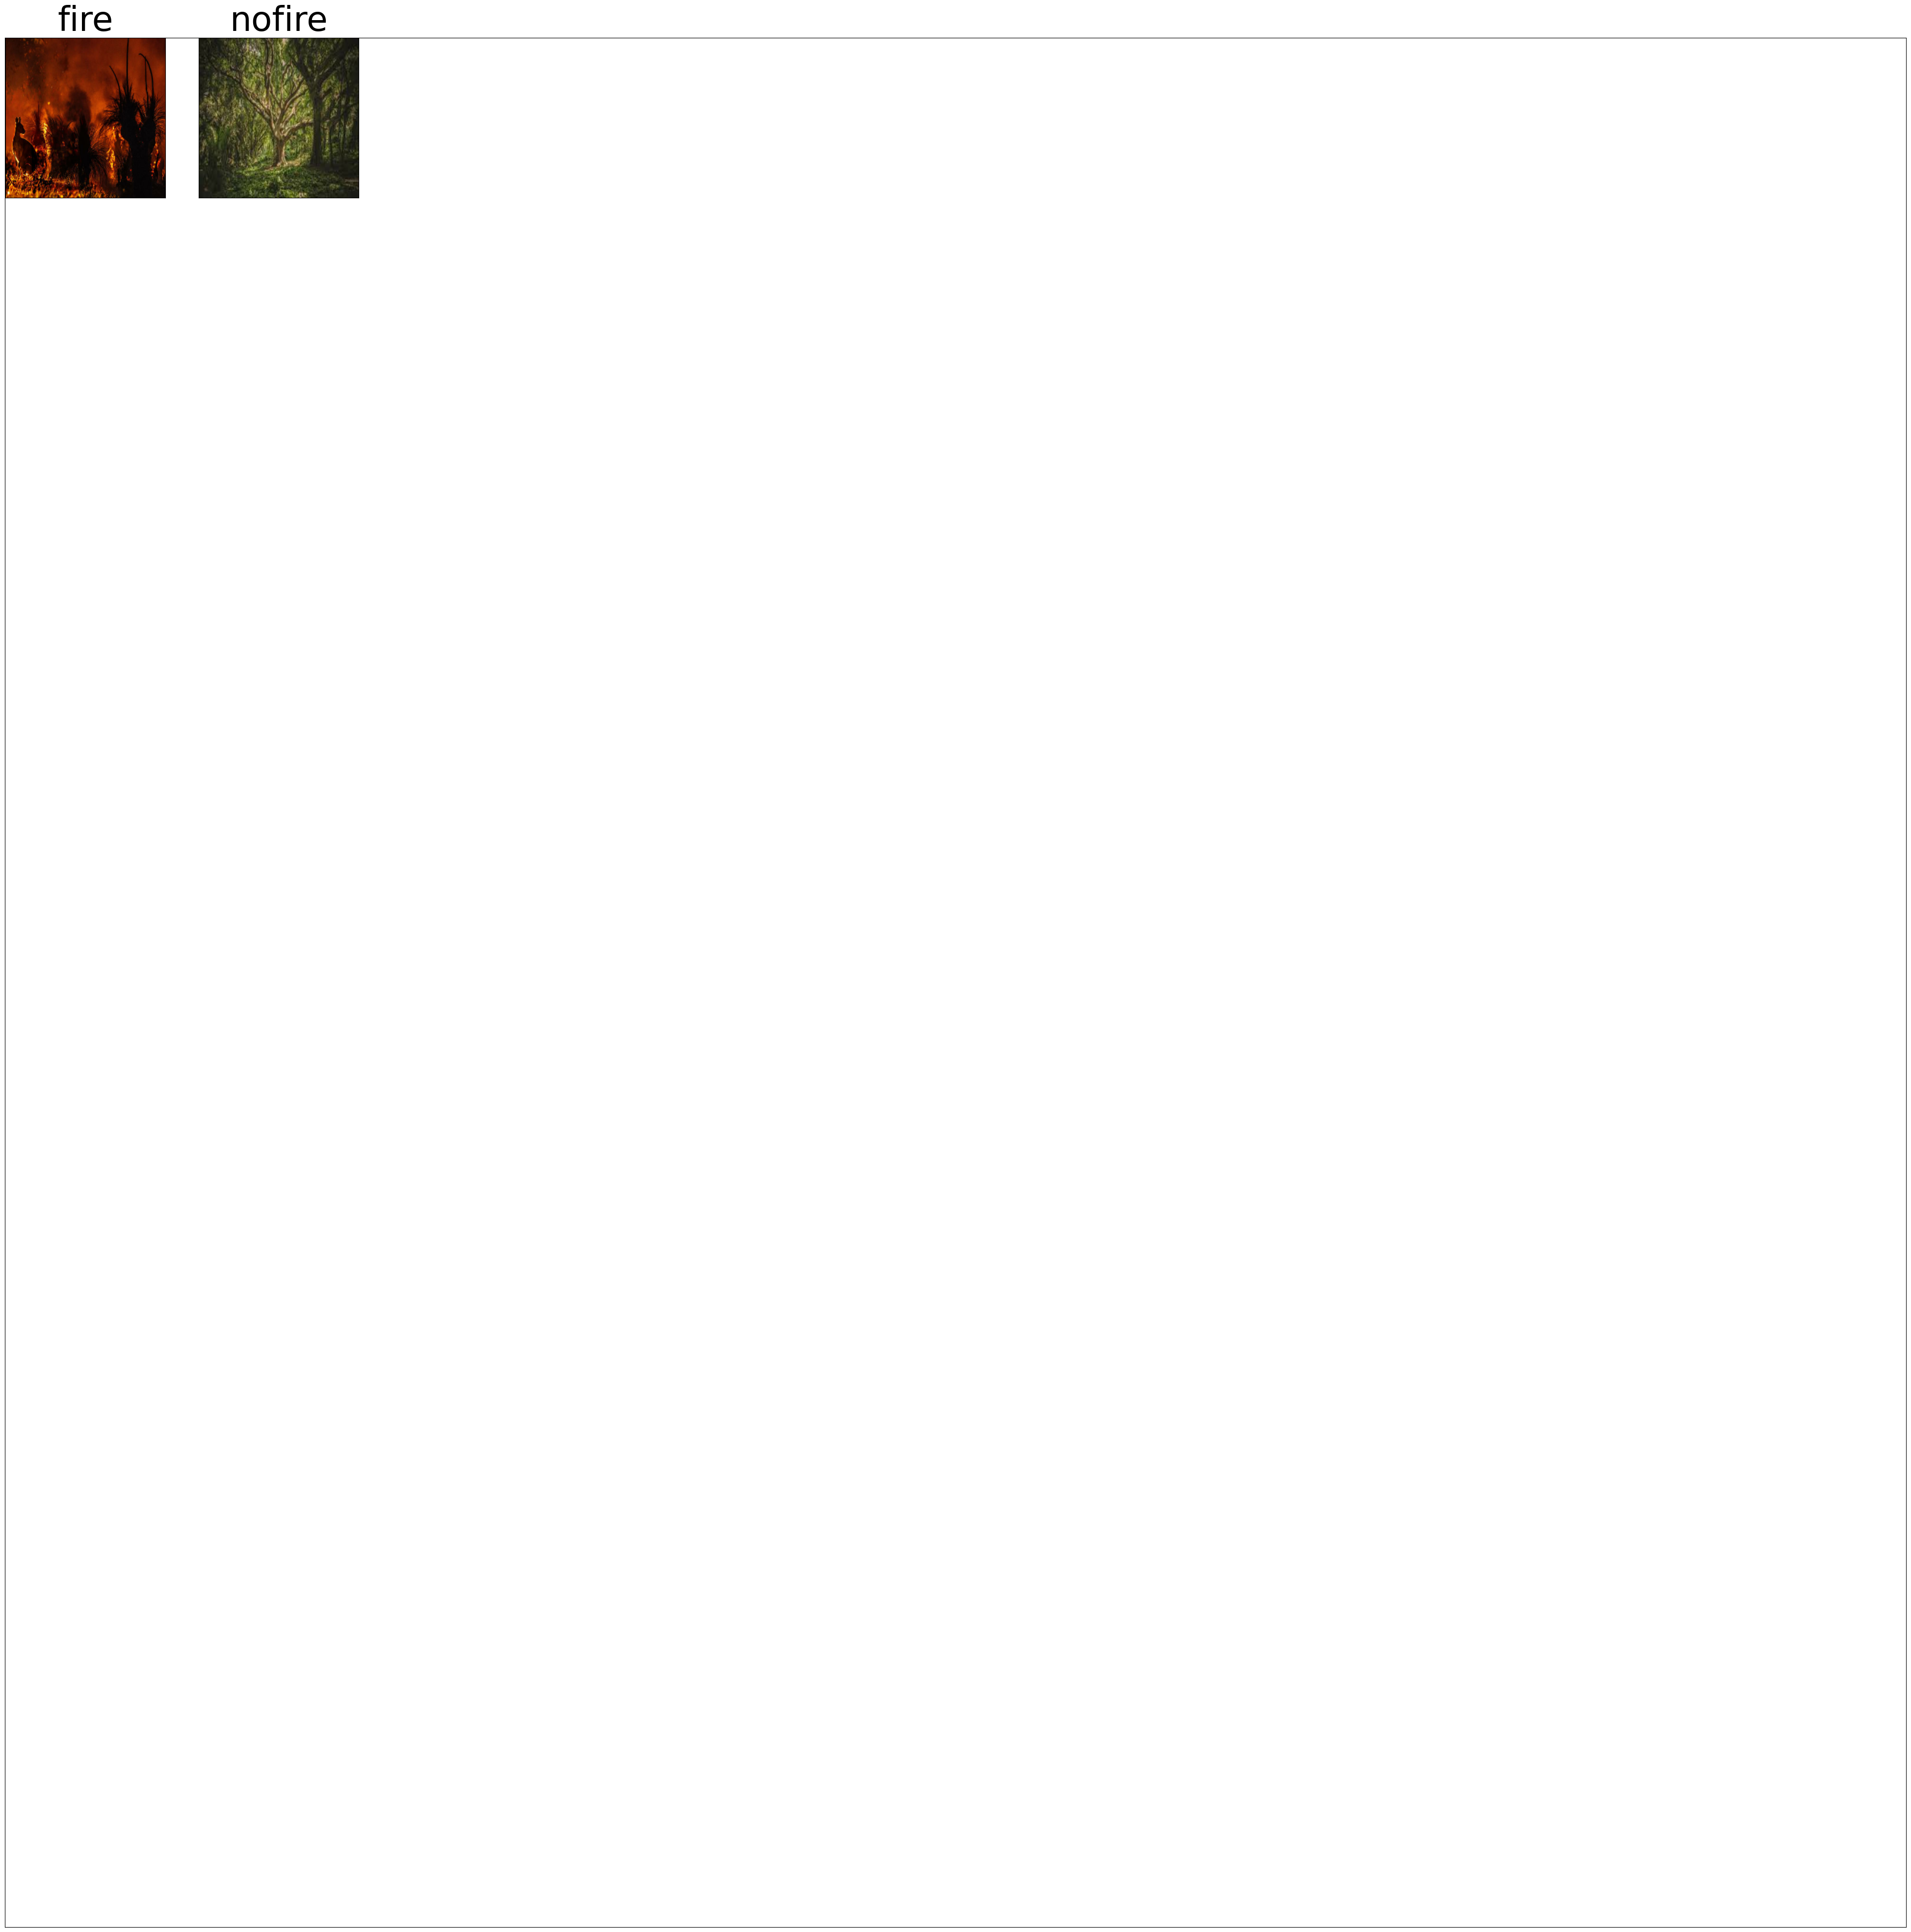

In [9]:
# Define function to create training and testing dataset
# data_filenames is train_filenames or test_filenames.

def create_dataset(data_filenames):
    
    # Create empty list for images and target (ie label: 1 is fire, 0 is nonfire)
    # The lists will be converted into tensor at the end
    image_dataset = []
    target = []    
    a = 0    # index for plotting subplot
    axes = []
    rows = 10
    cols = 10
    fig = plt.figure(figsize = (50, 50))
    ax = plt.gca()
    
    for filename in data_filenames:
        # Read each image file
        image_file = tf.io.read_file(filename)
            
        # try/catch if a file is not jpeg 
        try:
            image = tf.image.decode_jpeg(image_file)
        except:
            print("Not a jpeg file: ", image_file)
        
        # Split filename by "/". The category of fire or nonfire is the second element on the filename
        category = filename.split("/")[1]
        if category == "fire":
            label = 1
        else: label = 0
      
        # Resize image, Xception model expect size 224x224 images
        # Can't do resize_with_crop_or_pad, not compatible with Xception preprocess_input()
        #resize_image = tf.image.resize_with_crop_or_pad(image, 224, 224)
        resize_image = tf.image.resize(image, [224, 224])
   
        # Xception model needs run data through preprocess_input function
        final_image = keras.applications.xception.preprocess_input(resize_image)
        
        # Write image and label to datset
        image_dataset.append(np.array(final_image))
        target.append(label)
    
        # Display image with title (fire or nonfire category that's associated)
        axes.append(fig.add_subplot(rows,cols, a+1))
        plt.imshow(resize_image/255)
        plt.title(category, fontsize=50)
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) # get rid of ticks on x-axis and y-axis
        a += 1
    return image_dataset, target
      
"""      
        # Below is different data augmentation to increase dataset counts
        
        # flip left-right
        image_flipLR = tf.image.flip_left_right(resize_image)
        final_image = keras.applications.xception.preprocess_input(image_flipLR)
        # Write image and label to datset, still the same label
        image_dataset.append(np.array(final_image))
        target.append(label)

        # flipt up-down
        image_flipUD = tf.image.flip_up_down(resize_image)
        final_image = keras.applications.xception.preprocess_input(image_flipUD)
        image_dataset.append(np.array(final_image))
        target.append(label)
    
        # flipt left-right then up-down
        image_flipLRUD = tf.image.flip_up_down(image_flipLR)
        final_image = keras.applications.xception.preprocess_input(image_flipLRUD)
        image_dataset.append(np.array(final_image))
        target.append(label)
"""      
        
             
# Call the create_dataset() function to create train and test datasets
train_image_dataset, train_target = create_dataset(train_filenames)

test_image_dataset, test_target = create_dataset(test_filenames)

# Convert train_data from a list to a tensor
train_image_dataset = tf.convert_to_tensor(train_image_dataset, dtype=tf.float32)
print('Training image dataset shape: ', train_image_dataset.shape)

# Do the same for train_target
train_target = tf.convert_to_tensor(train_target, dtype=tf.uint8)

# Convert test_data from a list to tensor
test_image_dataset = tf.convert_to_tensor(test_image_dataset, dtype=tf.float32)
print('Testing image dataset shape: ', test_image_dataset.shape)

# Do the same for test_target
test_target = tf.convert_to_tensor(test_target, dtype=tf.uint8)


# Save Proprocessed Datasets on S3

In [10]:
# Save datasets in .npy files

np.save('train_image_dataset2.npy', train_image_dataset)
np.save('train_target2.npy', train_target)
np.save('test_image_dataset2.npy', test_image_dataset)
np.save('test_target2.npy', test_target)


In [19]:
# Save .npy file on S3

import sagemaker
import boto3
import re
from sagemaker import get_execution_role

region = 'us-east-2'
bucket = 'wildfires'

# Set up the region using boto3
boto_session = boto3.Session(region_name=region)  
sagemaker_session = sagemaker.Session(boto_session=boto_session)
role = get_execution_role()
s3_client = boto3.client('s3', region_name=region)

s3_client.upload_file('train/data.npy', bucket, 'data/train/data.npy')
s3_client.upload_file('train/labels.npy', bucket, 'data/train/labels.npy')
s3_client.upload_file('validation/data.npy', bucket, 'data/validation/data.npy')
s3_client.upload_file('validation/labels.npy', bucket, 'data/validation/labels.npy')

# Train Model on SageMaker

In [22]:
%%writefile train.py

import sagemaker
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import argparse
import os
from sagemaker.tensorflow import TensorFlow
from sagemaker import image_uris
import boto3

region = 'us-east-2'
bucket = 'wildfires'
prefix = ''

# Set up the region using boto3
boto_session = boto3.Session(region_name=region)  
sagemaker_session = sagemaker.Session(boto_session=boto_session)


def build_model(n_classes=2):
    # Use Xception as the base model
    base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
    
    # Output from the base model
    avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

    # Only two classes for softmax
    output = keras.layers.Dense(n_classes, activation="softmax")(avg)

    # Combine base_model and softmax for our model
    model = keras.Model(inputs=base_model.input, outputs=output)
    
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    return model


def train_model(train_dataset, validation_dataset, epochs, batch_size, learning_rate, model_dir):
    # Define model
    model = build_model()

    # Learning Rate Scheduler
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        train_dataset.batch(batch_size),
        validation_data=validation_dataset.batch(batch_size),
        epochs=epochs,
        #callbacks=[
        #    tf.keras.callbacks.TensorBoard(log_dir=os.path.join(output_dir, 'logs')),
        #    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'model_checkpoint'), save_best_only=True)
        #]
    )
    
    # Save the trained model
    model.save(args.model_dir) # Save the model to the SM_MODEL_DIR, which SageMaker automatically maps to the output_path:
    
#@tf.function
def load_data(data_path):
    # Assuming data and labels are saved as numpy arrays
    data = np.load(os.path.join(data_path, 'data.npy'))
    labels = np.load(os.path.join(data_path, 'labels.npy'))
    
    # Create a tf.data.Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    return dataset

if __name__ == '__main__':
    # SageMaker passes hyperparameters and directories as arguments
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--epochs', type=int, default=5)
    parser.add_argument('--batch-size', type=int, default=32)
    parser.add_argument('--learning-rate', type=float, default=0.01)
    parser.add_argument('--momentum', type=float, default=0.9)
    parser.add_argument('--decay', type=float, default=0.01)

    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument("--model_dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--train_dir", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument('--validation_dir', type=str, default=os.environ['SM_CHANNEL_VALIDATION'])
    parser.add_argument("--hosts", type=list, default=json.loads(os.environ.get("SM_HOSTS")))
    parser.add_argument("--current-host", type=str, default=os.environ.get("SM_CURRENT_HOST"))

    args = parser.parse_args()

    # Load training and validation datasets
    train_dataset = load_data(args.train_dir)
    validation_dataset = load_data(args.validation_dir)

    # Train the model
    train_model(
        train_dataset,
        validation_dataset,
        args.epochs,
        args.batch_size,
        args.learning_rate,
        args.model_dir
    )

        # Save the model to the specified model directory
    #train_model.save(os.path.join(args.model_dir, 'my_model.h5'))

Overwriting train.py


In [23]:
# Estimator

import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import image_uris
import boto3

region = 'us-east-2'
bucket = 'wildfires'

# Set up the region using boto3
boto_session = boto3.Session(region_name=region)  
sagemaker_session = sagemaker.Session(boto_session=boto_session)

# Define paths for training and validation data in S3
train_s3_path = 's3://{}/data/train/'.format(bucket)
validation_s3_path = 's3://{}/data/validation/'.format(bucket)

# Get the TensorFlow image URI
container = image_uris.retrieve(
    framework='tensorflow',
    region=region,
    version='2.11.0',
    py_version='py39',
    instance_type='ml.m5.large',
    image_scope='training'  # 'training' or 'inference'
)

# Create the TensorFlow estimator
tf_estimator = TensorFlow(
    entry_point='train.py',       # Path to your training script
    role=sagemaker.get_execution_role(),
    region=region,
    instance_count=1,
    instance_type='ml.m5.large',  # Adjust based on your needs
    framework_version='2.11.0',   # Match the TensorFlow version you're using
    py_version='py39',
    image_uri=container,  # Use image_uri instead of image_name
    #image_name='763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.11.0-cpu-py39-ubuntu18.04',
    hyperparameters={
        'epochs': 2,
        'batch-size': 6,
        'learning-rate': 0.01,
        'momentum': 0.9,
        'decay': 0.01
    },
    input_mode='File',
    script_mode=True,
    sagemaker_session = sagemaker_session,
    output_path='s3://{}/output'.format(bucket),
)

# Launch the training job
tf_estimator.fit({
    'train': train_s3_path,  
    'validation': validation_s3_path}
)


INFO:sagemaker:Creating training-job with name: tensorflow-training-2024-10-22-20-15-00-472


2024-10-22 20:15:00 Starting - Starting the training job...
2024-10-22 20:15:21 Starting - Preparing the instances for training...
2024-10-22 20:15:44 Downloading - Downloading input data...
2024-10-22 20:16:29 Downloading - Downloading the training image........2024-10-22 20:17:44.743837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 20:17:44.847452: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-22 20:17:44.848199: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-10-22 20:17:44.878274: W tensorflow/core/profil

In [112]:
pwd


'/home/sagemaker-user/Wildfire-Detection-with-Deep-CNN'

In [33]:
# The following in terminal
"""
aws s3 cp s3://wildfires/output/tensorflow-training-2024-10-22-20-15-00-472/model/ ./model/ --recursive

tar -czvf model.tar.gz -C ./model .
"""

SyntaxError: invalid syntax (3447411487.py, line 1)

In [34]:
# Save model.tar.gz to S3
s3_client.upload_file('model.tar.gz', bucket, 'model/model.tar.gz')

# Deploy the Model

In [35]:
%%writefile entry_point.py

import sagemaker
import os
import tensorflow as tf
from tensorflow import keras
from sagemaker_tensorflow_serving_container.handler_service import HandlerService


def preprocess_input(filename):
    # Read each image file
    image_file = tf.io.read_file(filename)
    
    # try/catch if a file is not jpeg
    try:
        image = tf.image.decode_jpeg(image_file)
    except:
        print("Not a jpeg file: ", filename)
        return None
    
    # Resize image, Xception model expects 224x224 size
    resize_image = tf.image.resize(image, [224, 224])
   
    # Xception model needs data processed with preprocess_input
    final_image = keras.applications.xception.preprocess_input(resize_image)

    # Add batch dimension (1, height, width, channels)
    return tf.expand_dims(final_image, axis=0)

class WildfirePredictor(HandlerService):
    def __init__(self):
        super(WildfirePredictor, self).__init__()
        # Path where the model is stored after SageMaker downloads it from S3
        self.model_path = 's3://wildfires/model/model.tar.gz'
        self.model = None

    def load_model(self):
        # Load the TensorFlow model from the SageMaker model directory
        self.model = tf.keras.models.load_model(self.model_path)

    def preprocess(self, data):
        # Preprocess image data
        processed_data = preprocess_input(data)
        return processed_data

    def predict(self, data):
        # Run prediction
        processed_data = self.preprocess(data)
        if processed_data is None:
            return "Error: Invalid image file"
        predictions = self.model(processed_data)
        return predictions.numpy().tolist()
        

Overwriting entry_point.py


In [36]:
import sagemaker
from sagemaker.tensorflow import TensorFlowModel

sagemaker_model = TensorFlowModel(model_data='s3://wildfires/model/model.tar.gz',
                                 role=sagemaker.get_execution_role(),
                                 framework_version='2.11',
                                 entry_point='entry_point.py'
                                 )

# Deploy the model to a SageMaker endpoint
predictor = sagemaker_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-inference-2024-10-22-20-54-09-346
INFO:sagemaker:Creating endpoint-config with name tensorflow-inference-2024-10-22-20-54-10-043
INFO:sagemaker:Creating endpoint with name tensorflow-inference-2024-10-22-20-54-10-043


------------------------------------------*

UnexpectedStatusException: Error hosting endpoint tensorflow-inference-2024-10-22-20-54-10-043: Failed. Reason: The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint.. Try changing the instance type or reference the troubleshooting page https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-troubleshooting.html

## Change instant type

In [40]:
import sagemaker
from sagemaker.tensorflow import TensorFlowModel

sagemaker_model = TensorFlowModel(model_data='s3://wildfires/model/model.tar.gz',
                                 role=sagemaker.get_execution_role(),
                                 framework_version='2.11',
                                 entry_point='entry_point.py'
                                 )

# Deploy the model to a SageMaker endpoint
predictor = sagemaker_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.2xlarge'
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-inference-2024-10-22-21-28-38-540
INFO:sagemaker:Creating endpoint-config with name tensorflow-inference-2024-10-22-21-28-39-301
INFO:sagemaker:Creating endpoint with name tensorflow-inference-2024-10-22-21-28-39-301


------------------------------------------*

UnexpectedStatusException: Error hosting endpoint tensorflow-inference-2024-10-22-21-28-39-301: Failed. Reason: The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint.. Try changing the instance type or reference the troubleshooting page https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-troubleshooting.html

## Adding load-model()

In [41]:
%%writefile entry_point.py

import sagemaker
import os
import tensorflow as tf
from tensorflow import keras
from sagemaker_tensorflow_serving_container.handler_service import HandlerService


def preprocess_input(filename):
    # Read each image file
    image_file = tf.io.read_file(filename)
    
    # try/catch if a file is not jpeg
    try:
        image = tf.image.decode_jpeg(image_file)
    except:
        print("Not a jpeg file: ", filename)
        return None
    
    # Resize image, Xception model expects 224x224 size
    resize_image = tf.image.resize(image, [224, 224])
   
    # Xception model needs data processed with preprocess_input
    final_image = keras.applications.xception.preprocess_input(resize_image)

    # Add batch dimension (1, height, width, channels)
    return tf.expand_dims(final_image, axis=0)

class WildfirePredictor(HandlerService):
    def __init__(self):
        super(WildfirePredictor, self).__init__()
        # Path where the model is stored after SageMaker downloads it from S3
        self.model_path = 's3://wildfires/model/model.tar.gz'
        self.model = None

    def load_model(self):
        # Load the TensorFlow model from the SageMaker model directory
        self.model = tf.keras.models.load_model(self.model_path)

    def preprocess(self, data):
        # Preprocess image data
        processed_data = preprocess_input(data)
        return processed_data

    def predict(self, data):
        # Run prediction
        processed_data = self.preprocess(data)
        self.load_model()
        if processed_data is None:
            return "Error: Invalid image file"
        predictions = self.model(processed_data)
        return predictions.numpy().tolist()

Overwriting entry_point.py


In [42]:
import sagemaker
from sagemaker.tensorflow import TensorFlowModel

sagemaker_model = TensorFlowModel(model_data='s3://wildfires/model/model.tar.gz',
                                 role=sagemaker.get_execution_role(),
                                 framework_version='2.11',
                                 entry_point='entry_point.py'
                                 )

# Deploy the model to a SageMaker endpoint
predictor = sagemaker_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-inference-2024-10-22-22-15-26-773
INFO:sagemaker:Creating endpoint-config with name tensorflow-inference-2024-10-22-22-15-27-470
INFO:sagemaker:Creating endpoint with name tensorflow-inference-2024-10-22-22-15-27-470


-------------------------------------------*

UnexpectedStatusException: Error hosting endpoint tensorflow-inference-2024-10-22-22-15-27-470: Failed. Reason: The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint.. Try changing the instance type or reference the troubleshooting page https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-troubleshooting.html

# Inference

In [135]:
# Inference
reponse_1 = predictor.predict('test_fire.jpg')
print(response_1)

#response_2 = predictor.predict(test_nofire.jpg)
#print(response_2)

NameError: name 'predictor' is not defined

### Save model

In [126]:
# Save the model in the SavedModel format
tf.saved_model.save(tf_estimator, 'model/saved_model/')

# Alternatively, you can save it as a tar.gz file (recommended for SageMaker)
import tarfile

with tarfile.open('model/model.tar.gz', 'w:gz') as tar:
    tar.add('model/saved_model', arcname='saved_model')

ValueError: Expected an object of type `Trackable`, such as `tf.Module` or a subclass of the `Trackable` class, for export. Got <sagemaker.tensorflow.estimator.TensorFlow object at 0x7fefc84d9690> with type <class 'sagemaker.tensorflow.estimator.TensorFlow'>.

In [116]:
# Deploy the model

from sagemaker.tensorflow import TensorFlowModel
import sagemaker

bucket = 'my-sagemaker-region-1'
prefix = 'wildfires'
s3_model_path = 's3://my-sagemaker-region-1/wildfires/output/model/model.tar.gz/saved_model.pb' # Path to the model artifact in S3

# SageMaker execution role
role = sagemaker.get_execution_role()

# Get the TensorFlow image URI
container = image_uris.retrieve(
    framework='tensorflow',
    region=region,
    version='2.11.0',
    py_version='py39',
    instance_type='ml.m5.large',
    image_scope='inference'  # 'training' or 'inference'
)

# Define the model from the artifact
model = TensorFlowModel(
    model_data=s3_model_path,
    role=role,
    framework_version='2.11.0',   # Same TensorFlow version used during training
    image_uri=container, 
    #entry_point='inference.py'  # Optional: if you have custom inference code
)

predictor = model.deploy(
    initial_instance_count=1,  # Number of instances to deploy the model on
    instance_type='ml.m5.large'  # Change to the appropriate instance type
)


INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py39.
INFO:sagemaker:Creating model with name: tensorflow-inference-2024-10-16-22-02-27-493
INFO:sagemaker:Creating endpoint-config with name tensorflow-inference-2024-10-16-22-02-28-313
INFO:sagemaker:Creating endpoint with name tensorflow-inference-2024-10-16-22-02-28-313


--------*

UnexpectedStatusException: Error hosting endpoint tensorflow-inference-2024-10-16-22-02-28-313: Failed. Reason: Failed to extract model data archive from URL "s3://my-sagemaker-region-1/wildfires/output/model/model.tar.gz/saved_model.pb". Please ensure that the object located at the URL is a valid tar.gz archive.. Try changing the instance type or reference the troubleshooting page https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-troubleshooting.html

In [113]:
model_url = s3://my-sagemaker-region-1/wildfires/output/model/model.tar.gz/

predictor = tf_estimator.deploy(
    initial_instance_count=1,  # Number of instances to deploy the model on
    instance_type='ml.m5.large'  # Change to the appropriate instance type
)


INFO:sagemaker:Creating model with name: tensorflow-training-2024-10-16-17-24-40-852


ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Could not find model data at s3://my-sagemaker-region-1/wildfires/output/tensorflow-training-2024-10-16-17-03-31-837/output/model.tar.gz.

# Inference

In [117]:
# Process input image

import sagemaker
import tensorflow as tf
from tensorflow import keras

def preprocess_input(filename):
    
    abs # Read each image file
    image_file = tf.io.read_file(filename)
            
    # try/catch if a file is not jpeg 
    try:
       image = tf.image.decode_jpeg(image_file)
    except:
        print("Not a jpeg file: ", image_file)
        
    # Resize image, Xception model expect size 224x224 images
    # Can't do resize_with_crop_or_pad, not compatible with Xception preprocess_input()
    #resize_image = tf.image.resize_with_crop_or_pad(image, 224, 224)
    resize_image = tf.image.resize(image, [224, 224])
   
    # Xception model needs run data through preprocess_input function
    final_image = keras.applications.xception.preprocess_input(resize_image)
        
    #final_image = np.array(final_image)
    #final_image = tf.convert_to_tensor(final_image, dtype=tf.float32)

    return final_image

In [118]:
# Convert .jpg file to tensor
image_1 = preprocess_input('test_fire.jpg')
image_2 = preprocess_input('test_nofire.jpg')

In [120]:
# Inference
reponse_1 = predictor.predict(image_1)
print(response_1)

response_2 = predictor.predict(image_2)
print(response_2)

NameError: name 'predictor' is not defined

In [ ]:
# Convert to list (or prepare as JSON if necessary)
image_list = image_array.tolist()

# Set up the SageMaker predictor
sagemaker_runtime = boto3.client('sagemaker-runtime')
endpoint_name = 'your-endpoint-name'

# Make a prediction
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/json',  # Adjust if using a different format
    Body=json.dumps(image_list)  # Use the prepared list or JSON data
)

# Read the response
result = json.loads(response['Body'].read().decode())
print(result)

# Summary


**Creating Dataset** 

At first, I attempted to create TFRecord and extract data from it. However, I encountered dimensionality mismatch when extracted each example for training. So I had this alternative method. 

There are two folders with fire and nonfire images, each has 50 images to balance the two classes. After shuffling, 25% of the images were sent for testing and 75% for training. I wrote a create_dataset() function to convert the images into nested list which is then converted into tensor for dataset. The labels/targets corresponding to the images are saved into another file with the same order as the images. Each image is resized to (224, 224). The channels are preserved because color is important in detecting the wildfire. Data augmentation is applied by flipping images left-right and up-down to quadruple into 400 images.

**Model**

Deep convolution neural network is used for the model.  I built my model base on the pretrained Xception base model (proposed in 2016 by Francois Chollet, author of Keras), that has 132 layers, and then I added 2 or 3 layers on top of it. The weights are extracted from imagenet training and they are set as non-trainable. Xception model has depthwise separable convolution layers, which assume spatial patterns and cross-channel patterns can be modeled separately [1]. This saves computation time.   

**Results**

I graduatlly increase the data size, 108, 240, 320 and 400 total images after augmentation. The table and plot above show the best accuracy on test images among 4 different models-- initial model and three fine-tuned models. The accuracies were above 90%, exception one outlier at 87% for 400 images but 5 others times fall between 95% - 100%.  The outlier could be because there are one or two images that are very ambigeous that got into the test set, this becomes 4 or 8 images after augmentation. The accuracy for 108 images are low, but they were just quick test that my code works when I was developing models.

I tried three different ways to fine tune the model: 1. unfreezed the top layers, 2. added a dropout layer at the top layer, 3. changed the optimizer. Out of at least 12 times I ran the program, different strategies can do better or worse than the initial model.

The more data I have, the wider distribution the data can be, so it is not black-and-white (fire or nonfire). The model is robus enough to give excellent predictions. Thanks to the Xception model that I was able to transfer the learning. Computer vision with pretrained model is amazing in accuracy and simplicity!

## References:

1. Geron, Aurelien, Hands-on Machine Learning with SciKit-Learn, Keras & TensorFlow, 2nd Ed, O'Reilly